In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import pybaseball
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import xgboost as xgb
from supertree import SuperTree
import graphviz

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [5]:
pybaseball.cache.enable()

In [6]:
data = pybaseball.statcast(start_dt = "2023-06-13", end_dt = "2025-05-05")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 454/454 [00:54<00:00,  8.40it/s]
c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [7]:
filtered_data = data[["pitcher",
                      "pitch_type",
                      "batter",
                      "events",
                      "zone",
                      "p_throws",
                      "release_spin_rate",
                      "release_speed",
                      "launch_speed",
                      "launch_angle",
                      "release_pos_x",
                      "release_pos_y",
                      "release_pos_z",
                      "plate_x",
                      "plate_z",
                      "pfx_x",
                      "stand"
                      ]]

In [8]:
filtered_data = filtered_data.dropna(subset=["events"])
filtered_data = filtered_data.fillna(0)
#Dropping Certain Events
dropped_events = ["fielders_choice","fielders_choice_out",'catcher_interf','double_play','force_out','grounded_into_double_play','sac_fly_double_play','strikeout_double_play','triple_play',None]
for event in dropped_events:
    index= (filtered_data[(filtered_data["events"] == event)]).index
    filtered_data.drop(index,inplace= True)
#Dropping Pitchtype 0
index = (filtered_data[(filtered_data["pitch_type"] == 0)]).index
filtered_data.drop(index,inplace = True)
filtered_data.head()

,pitcher,pitch_type,batter,events,zone,p_throws,release_spin_rate,release_speed,launch_speed,launch_angle,release_pos_x,release_pos_y,release_pos_z,plate_x,plate_z,pfx_x,stand
4652,621242,FF,650968,single,11,R,2337,96.2,92.8,12,-2.28,53.6,4.86,-1.43,3.24,-1.04,R
4579,592773,FF,676480,field_out,11,R,2292,97.7,74.7,69,-0.37,54.63,6.69,-0.14,3.89,-0.66,R
4401,700241,ST,668901,strikeout,7,R,2491,84.2,0.0,0,-2.44,53.68,5.67,-0.43,1.6,0.91,R
4216,656731,SL,680977,field_out,13,R,2497,84.1,96.5,21,-2.98,53.84,6.01,-0.91,2.19,0.39,L
4738,656731,FF,663457,field_out,11,R,2158,92.9,101.1,43,-2.93,53.47,6.02,-0.43,3.72,-0.68,L


In [9]:
events = filtered_data["pitch_type"].unique()
print(events)

['FF' 'ST' 'SL' 'FS' 'FC' 'SI' 'CU' 'CH' 'KC' 'EP' 'FA' 'SV' 'FO' 'KN'
 'SC']


In [10]:
le = LabelEncoder()
filtered_data["p_throws"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["pitch_type"] = le.fit_transform(filtered_data["pitch_type"])
filtered_data["stand"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["events"] = le.fit_transform(filtered_data["events"])


In [11]:
#Get name mappings
le_name_mapping = dict(zip(le.classes_,le.transform(le.classes_)))
print(le_name_mapping)

{'double': 0, 'field_error': 1, 'field_out': 2, 'hit_by_pitch': 3, 'home_run': 4, 'sac_bunt': 5, 'sac_fly': 6, 'single': 7, 'strikeout': 8, 'triple': 9, 'truncated_pa': 10, 'walk': 11}


In [15]:
y = filtered_data[["events"]]
x = filtered_data.drop("events",axis = 1)

In [ ]:
#Attempting to see if PCA on our data set is a good idea before feeding into our model
pca = PCA()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
pca.explained_variance_ratio_

array([2.88271445e-01, 2.36796567e-01, 1.09175071e-01, 7.91497924e-02,
       7.82477379e-02, 7.41938046e-02, 4.68010186e-02, 3.34344584e-02,
       2.67530973e-02, 1.36475997e-02, 9.10062567e-03, 4.42878172e-03,
       2.50851915e-17])

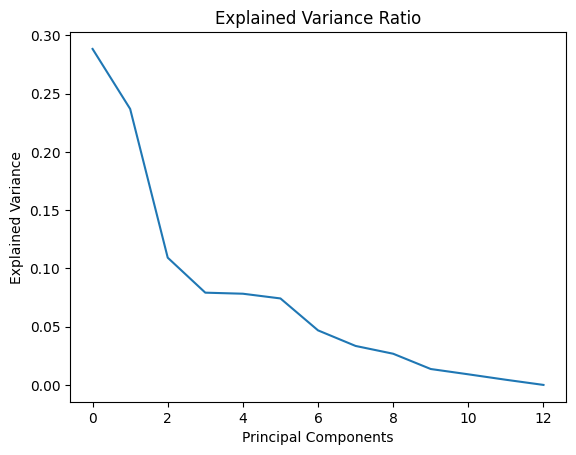

[2.88271445e-01 2.36796567e-01 1.09175071e-01 7.91497924e-02
 7.82477379e-02 7.41938046e-02 4.68010186e-02 3.34344584e-02
 2.67530973e-02 1.36475997e-02 9.10062567e-03 4.42878172e-03
 2.50851915e-17]


In [ ]:
# Plot
plt.plot(range(0,13), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()
print(pca.explained_variance_ratio_)

We can conclude that PCA is not a good fit, we would need almost 10 PCs to have a 95%+ explained variance ratio. Since we only have 15 predictors, PCA was not a good fit for dimension reduction for our data set.

<Axes: >

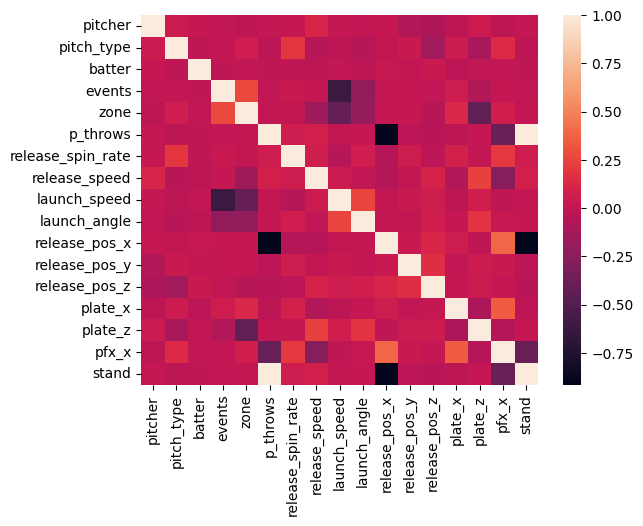

In [ ]:
#Plotting Correlation Heatmap 
sns.heatmap(filtered_data.corr())

In [16]:
#Random_state 10
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,shuffle=True)
x_test.shape
x_train.shape

(3733, 16)

In [60]:
clf = xgb.XGBClassifier(objective="multi:softmax",
                        num_class = 12,
                        n_estimators = 50,
                        random_state = 10,
                        learning_rate = 0.3,
                        max_depth = 5)
clf.fit(x_train,y_train)
y_probs = clf.predict(x_test)

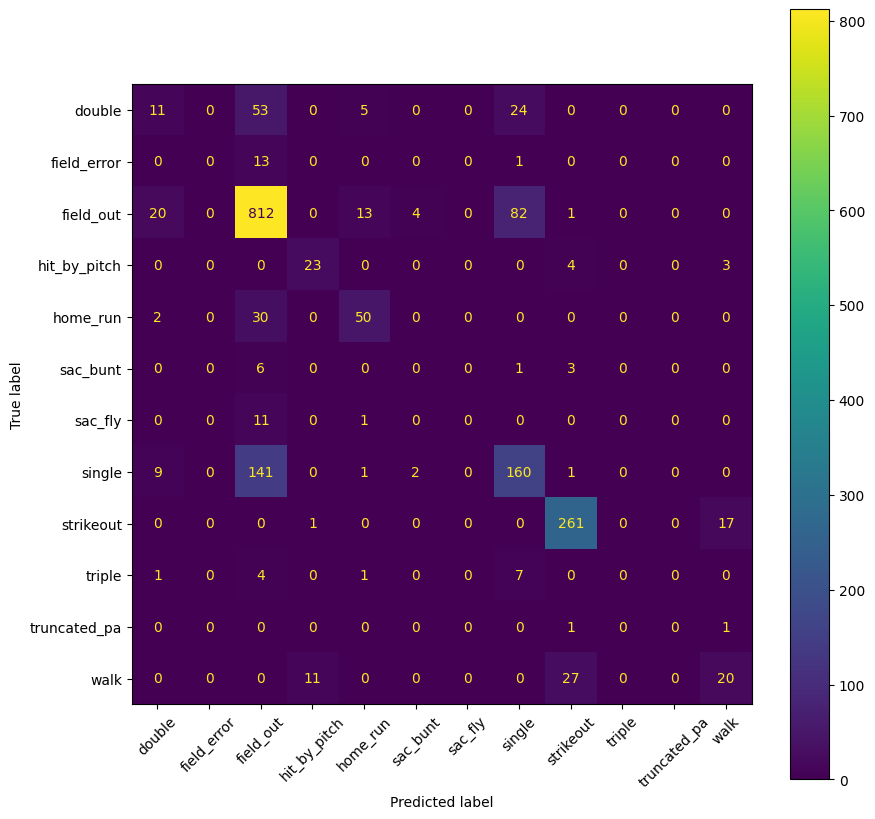

In [38]:
cm = confusion_matrix(y_test,y_probs)
disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels=le_name_mapping)
fig,ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax,xticks_rotation=45)

In [39]:
print(classification_report(y_probs,y_test))

              precision    recall  f1-score   support

           0       0.12      0.26      0.16        43
           1       0.00      0.00      0.00         0
           2       0.87      0.76      0.81      1070
           3       0.77      0.66      0.71        35
           4       0.61      0.70      0.65        71
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         0
           7       0.51      0.58      0.54       275
           8       0.94      0.88      0.90       298
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.34      0.49      0.40        41

    accuracy                           0.73      1839
   macro avg       0.35      0.36      0.35      1839
weighted avg       0.78      0.73      0.75      1839



In [40]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances,index = x.columns)

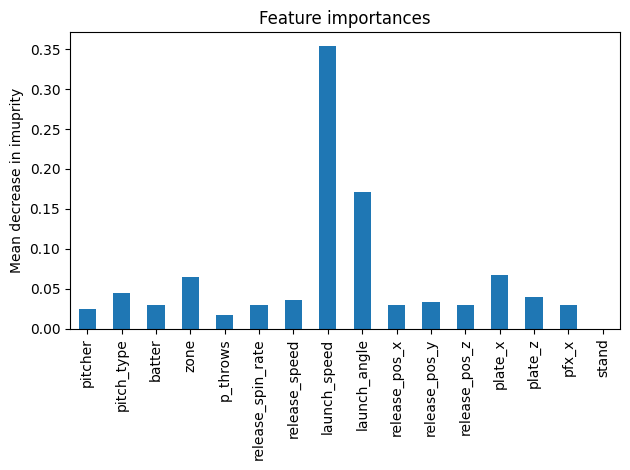

In [42]:
fig, ax = plt.subplots()
forest_importances.plot.bar( ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in imuprity")
fig.tight_layout()

c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

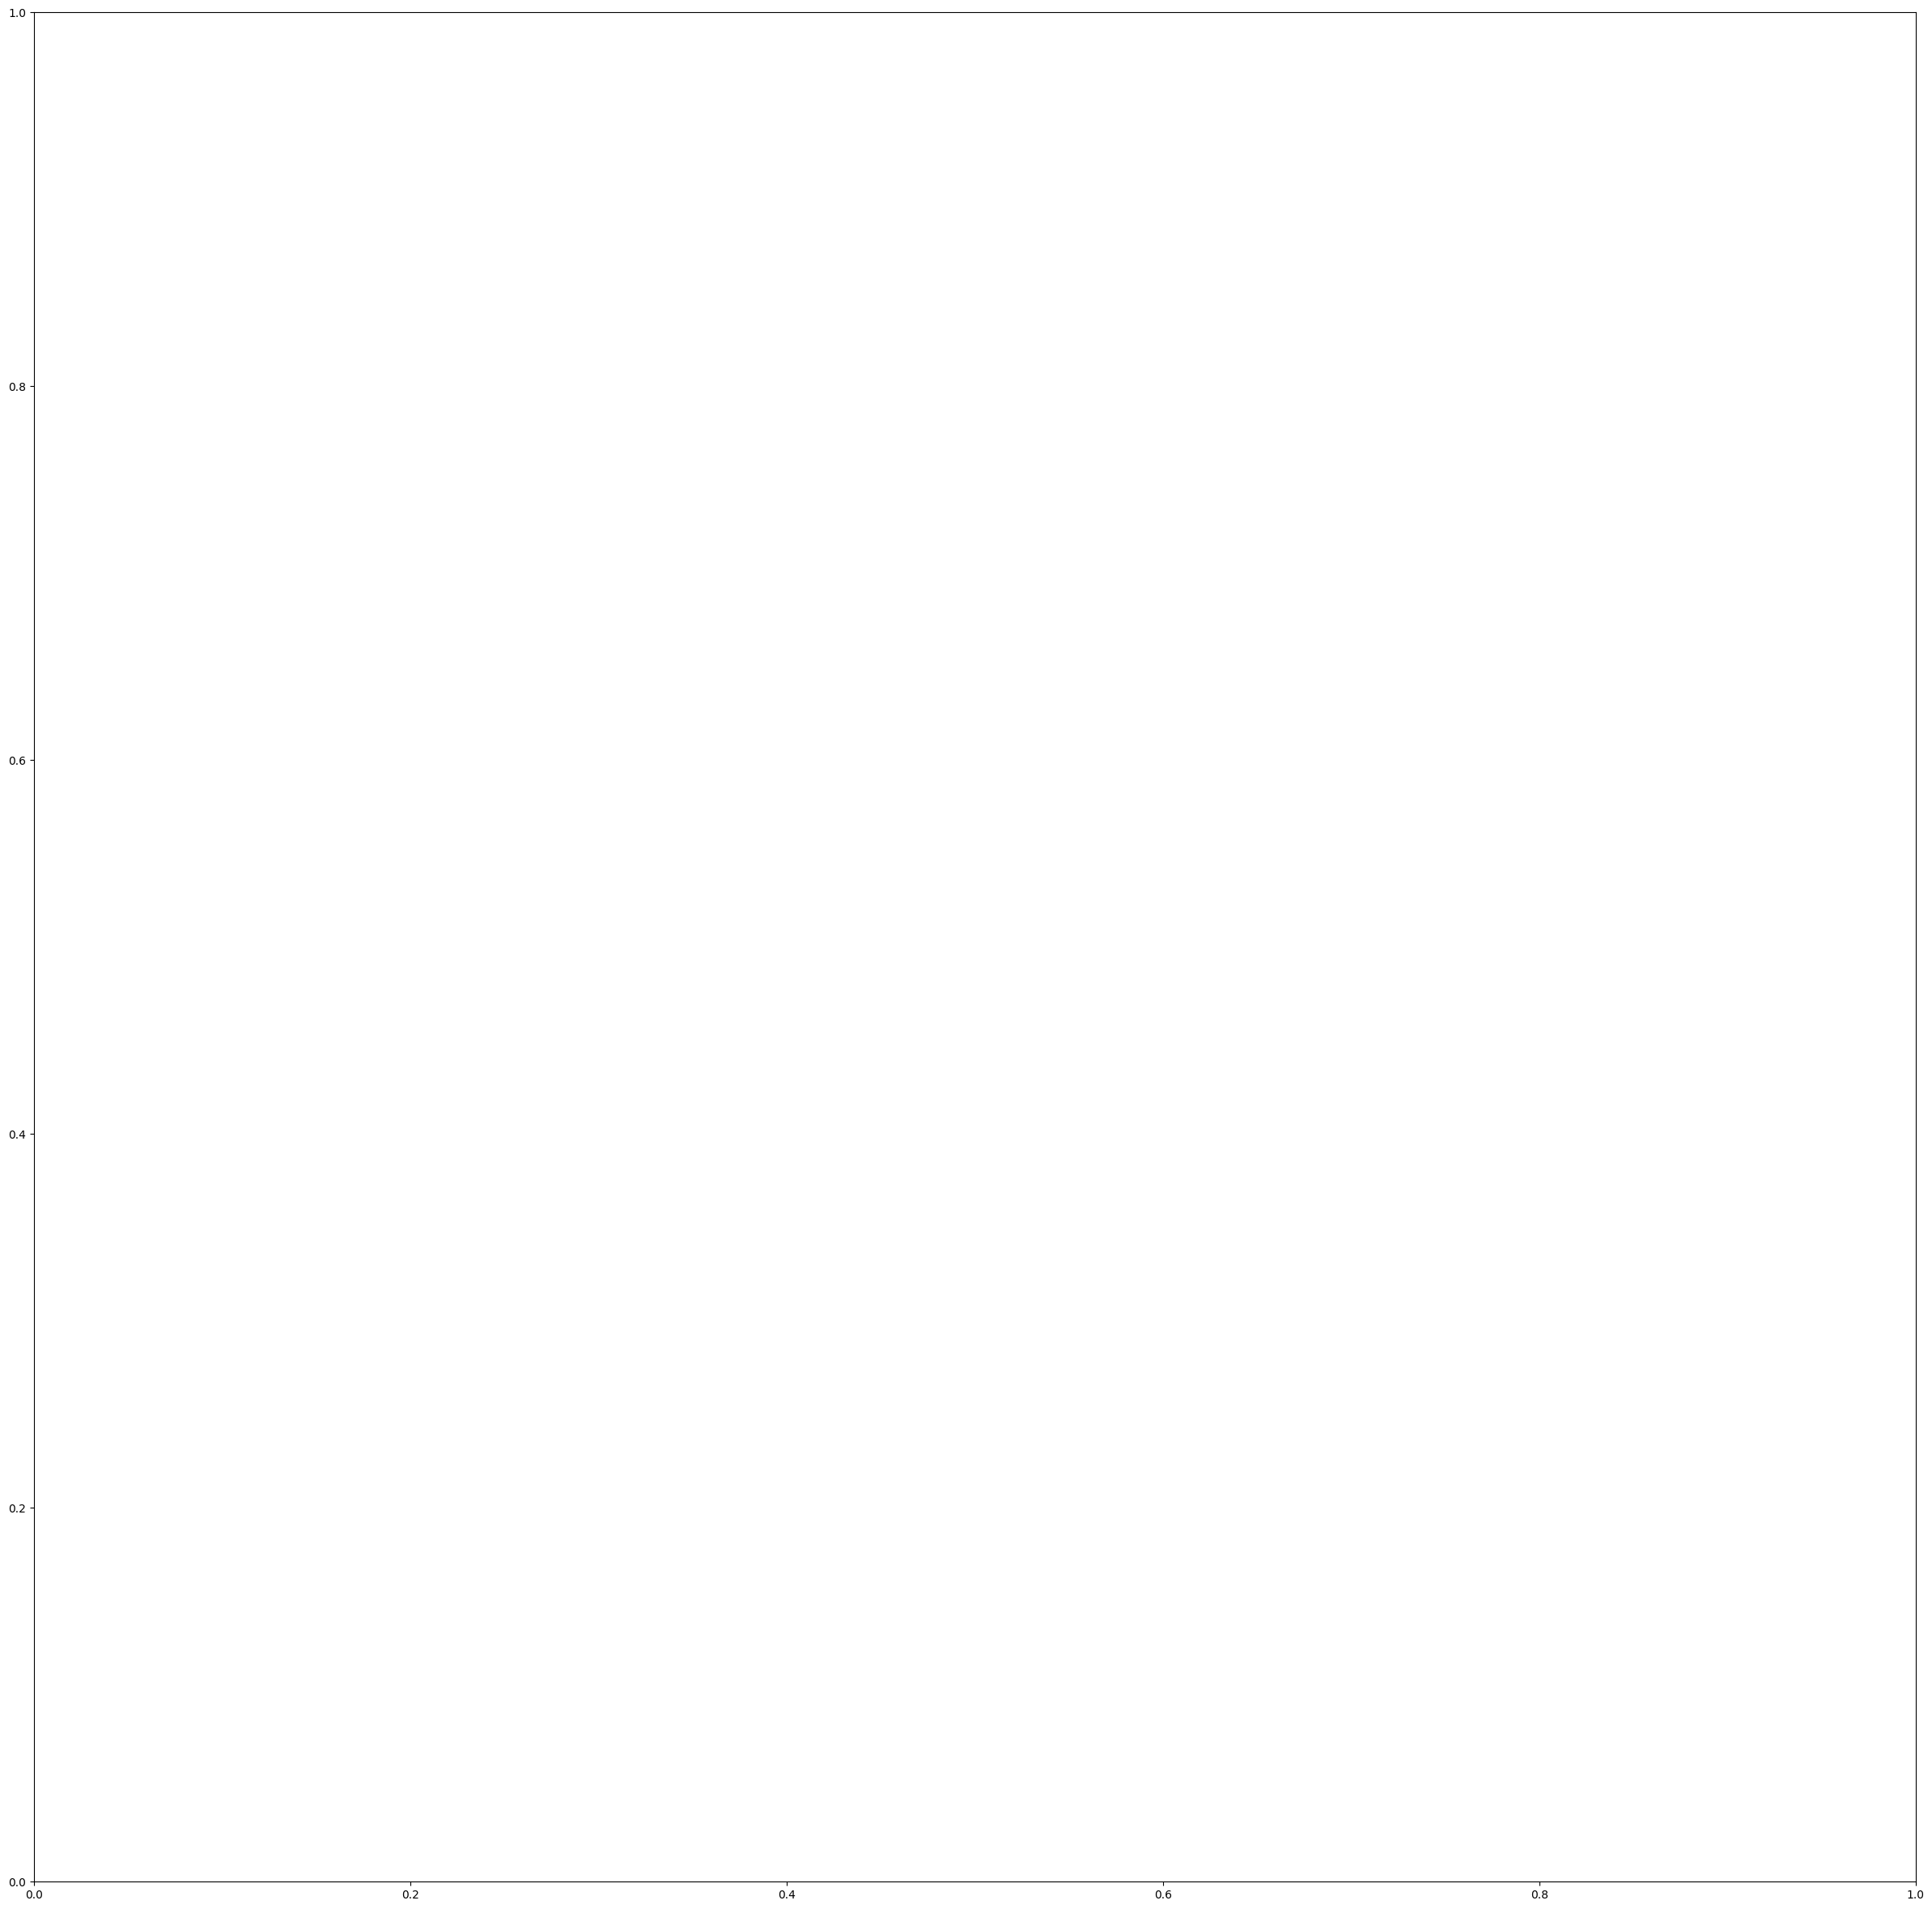

In [74]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(clf, num_trees=4, ax=ax)
plt.show()